In [1]:
## Problem 1.2

### K-means clustering

- initialize the first k centers using kmeans++ algorithm
- E-step
- M-step
- compute loss and check if changed (centers change => loss change)

### Init first k centers

- choose first point randomly
- for remaining k-1 points
- for each data point, pick the closest center and compute its distance
- probably pick a point farther from the closest point (proportional to distance squared)
- update the list of centers and repeat

### E-step

Assign the clusters based on the closest centroid

### M-step

Find centroids of the clusters thus obtained

### Loss computation

For each data point in each cluster, compute the distance to its centroid

Initial loss is inf

In [2]:
### Packages

import math
import numpy as np

from matplotlib import pyplot as plt

In [3]:
rng = np.random.default_rng(seed=143)

In [4]:
def sample_mixture(sigma):
    # sample 100 points given mean and covariance

    # Distribution 1
    meana = [-1, -1]
    cova = sigma * np.array([[2, 0.5], [0.5, 1]])
    samplea = rng.multivariate_normal(meana, cova, size=100)
    
    # Distribution 2
    meanb = [1, -1]
    covb = sigma * np.array([[1, -0.5], [-0.5, 2]])
    sampleb = rng.multivariate_normal(meanb, covb, size=100)
    
    # Distribution 3
    meanc = [0, 1]
    covc = sigma * np.array([[1, 0], [0, 2]])
    samplec = rng.multivariate_normal(meanc, covc, size=100)
    
    return np.concatenate((samplea, sampleb, samplec), axis=0)

In [5]:
## k-means++

def init_centroids(X):
    centers = np.empty((k, 2)) # store the k centroids

    n = X.shape[0]
    candidates = set(np.arange(n)) # list of candidate centroids

    cind = rng.integers(0, n) # pick the first one at random
    candidates.remove(cind)
    centers[0] = X[cind]

    for j in range(1, k):
        cands = list(candidates)
        nr = len(cands)
        dists = np.empty(nr)
        for i, candidate in enumerate(cands):
            # Compute minimum square distance to any of the centroids
            dists[i] = np.min(np.sum(np.square(X[candidate] - centers[:j]), axis=1))

        dists /= np.sum(dists)
        cind = cands[rng.choice(nr, p=dists)]
        candidates.remove(cind)
        centers[j] = X[cind]

    return centers

In [6]:
## closest centroid

def get_clusters(X, centers):
    n = X.shape[0]
    dists = np.empty((k, n))

    for i, center in enumerate(centers):
        dists[i] = np.sum(np.square(center - X), axis=1)

    return np.argmin(dists, axis=0)

In [7]:
## find centroids based on the clusters

def get_centroids(X, clusters):
    centers = np.empty((k, 2))

    for i in range(k):
        centers[i] = X[clusters == i].mean()

    return centers

In [8]:
# Compute loss given clusters and centers

def get_loss(X, clusters, centers):
    return sum([np.sum(np.square(X[clusters == i] - centers[i])) for i in range(k)])

In [9]:
def run_kmeans(X):
    prev_loss = float('inf')
    loss = prev_loss - 1

    centers = init_centroids(X)

    count = 0
    while not math.isclose(prev_loss, loss):
        prev_loss = loss
        clusters = get_clusters(X, centers)
        centers = get_centers(X, clusters)
        loss = get_loss(X, clusters, centers)
        count += 1

        if (count+1) % 100 == 0:
            print(f"{loss=:>7f} {count=:>5d}")

    return centers

In [10]:
def run_with_restarts(X):
    mloss = float('inf')
    mcenters = None
    
    for _ in range(1000):
        centers = run_kmeans(X)
        clusters = get_clusters(X, centers)
        loss = get_loss(X, clusters, centers)
        
        if loss < mloss:
            mloss = loss
            mcenters = centers
            
    return mcenters

In [11]:
def evaluate(X, centers):
    clusters = get_clusters(X, centers)
    n = len(clusters)
    true_clusters = np.empty(n, dtype=int)
    
    means = np.array([[-1, -1], [1, -1], [0, 1]])
    
    for i, center in enumerate(centers):
        cind = np.argmin(np.sum(np.square(center - means), axis=1))
        true_clusters[cind * 100 : (cind+1) * 100] = i
    
    acc = (clusters == true_clusters).mean()
    loss = get_loss(X, clusters, centers)
    
    return loss, acc

In [12]:
k = 3

sigmas = [0.5, 1, 2, 4, 8]
losses = []
accs = []

for i, sigma in enumerate(sigmas):
    X = sample_mixture(sigma)
    centers = run_with_restarts(X)
    loss, acc = evaluate(X, centers)
    losses.append(loss)
    accs.append(acc)

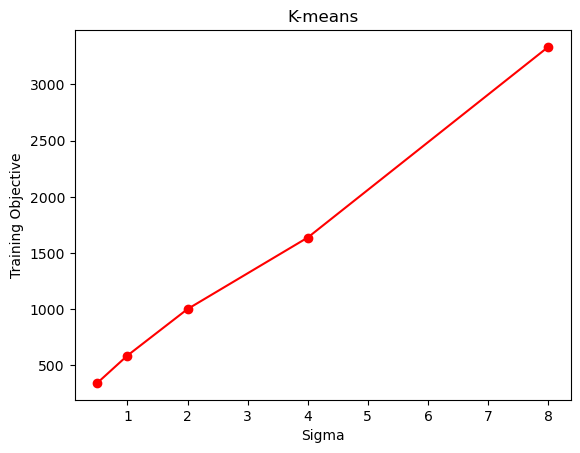

In [13]:
ax = plt.gca()

# Plotting
plt.plot(sigmas, losses, 'ro-')

# Labels and Title
plt.xlabel('Sigma')
plt.ylabel('Training Objective')
plt.title('K-means')

plt.show()

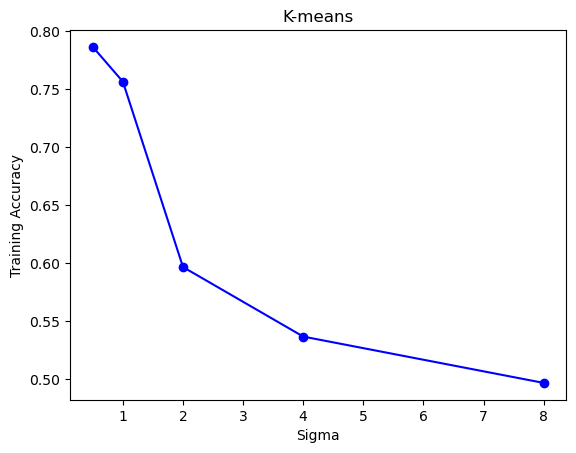

In [14]:
ax = plt.gca()

# Plotting
plt.plot(sigmas, accs, 'bo-')

# Labels and Title
plt.xlabel('Sigma')
plt.ylabel('Training Accuracy')
plt.title('K-means')

plt.show()

### GMM

- initialize the first k centers using kmeans++ algorithm
- assign w = prob(z | x) accordingly
- compute mean and covariance using this init
- E-step
- M-step
- compute loss and check if changed

### Init first k centers

- choose first point randomly
- for remaining k-1 points
- for each data point, pick the closest center and compute its distance
- probably pick a point farther from the closest point (proportional to distance squared)
- update the list of centers and repeat
- init w accordingly
- compute mean, cov, and loss

### E-step

- compute latents w
- w = p(x | z) p(z)
- p(x | z) is modelled as normal

### M-step

- compute params
- p(z) -> average w across points
- mean -> weighted avg of pos
- cov -> weighted avg of cov

### Loss computation

Negative log likelihood loss

For each data point, sum the joint prob as determined by each centroid

In [15]:
### Packages

import math
import numpy as np

from matplotlib import pyplot as plt

In [16]:
rng = np.random.default_rng(seed=42)

In [17]:
def sample_mixture(sigma):
    # sample 100 points given mean and covariance

    # Distribution 1
    meana = [-1, -1]
    cova = sigma * np.array([[2, 0.5], [0.5, 1]])
    samplea = rng.multivariate_normal(meana, cova, size=100)
    
    # Distribution 2
    meanb = [1, -1]
    covb = sigma * np.array([[1, -0.5], [-0.5, 2]])
    sampleb = rng.multivariate_normal(meanb, covb, size=100)
    
    # Distribution 3
    meanc = [0, 1]
    covc = sigma * np.array([[1, 0], [0, 2]])
    samplec = rng.multivariate_normal(meanc, covc, size=100)
    
    return np.concatenate((samplea, sampleb, samplec), axis=0)

In [18]:
## k-means++

def init_centroids(X):
    centers = np.empty((k, 2)) # store the k centroids

    n = X.shape[0]
    candidates = set(np.arange(n)) # list of candidate centroids

    cind = rng.integers(0, n) # pick the first one at random
    candidates.remove(cind)
    centers[0] = X[cind]

    for j in range(1, k):
        cands = list(candidates)
        nr = len(cands)
        dists = np.empty(nr)
        for i, candidate in enumerate(cands):
            # Compute minimum square distance to any of the centroids
            dists[i] = np.min(np.sum(np.square(X[candidate] - centers[:j]), axis=1))

        dists /= np.sum(dists)
        cind = cands[rng.choice(nr, p=dists)]
        candidates.remove(cind)
        centers[j] = X[cind]

    return centers

In [19]:
## closest centroid

def get_clusters(X, centers):
    n = X.shape[0]
    dists = np.empty((k, n))

    for i, center in enumerate(centers):
        dists[i] = np.sum(np.square(center - X), axis=1)

    return np.argmin(dists, axis=0)

In [20]:
def init_latents(X):
    # Get the centers using k-means++
    # and the corresponding cluster assignment
    centers = init_centroids(X)
    clusters = get_clusters(X, centers)
    n = X.shape[0]

    # Use the cluster assignment to assign initial probabilities
    # w[i, j] is 1 if point `i` is in cluster `j` and 0 otherwise
    w = np.zeros((n, k))
    clusters = np.expand_dims(clusters, axis=1)
    np.put_along_axis(w, clusters, 1, axis=1)
    
    return w

In [21]:
def update_params(X, w):
    # compute phi, mean, cov

    phi = np.mean(w, axis=0) # (k)
    
    # Normalize weights before computing mean and cov
    wsum = np.sum(w, axis=0) # (k)
    w /= wsum

    mean = w.T @ X # (k, d)
    Xc = X - np.expand_dims(mean, axis=1)
    cov = np.swapaxes(Xc, 1, 2) @ (np.expand_dims(w.T, axis=2) * Xc)

    return phi, mean, cov

In [22]:
def multivariate_gaussian_pdf(X, mean, covariance):
    d = mean.shape[1]
    covariance += 1e-3 * np.eye(2)
    det_cov = np.linalg.det(covariance)
    inv_cov = np.linalg.inv(covariance)
    constant = 1 / ((2 * np.pi)**(d/2) * np.sqrt(det_cov))
    Xc = np.expand_dims(X, axis=1) - mean
    exponent = -0.5 * (np.expand_dims(Xc, axis=2) @ inv_cov @ np.expand_dims(Xc, axis=3))
    exponent = np.squeeze(exponent)
    return constant * np.exp(exponent)

In [23]:
# Compute negative log likelihood

def get_loss(X, w, mean, cov):
    pdf = multivariate_gaussian_pdf(X, mean, cov)
    return -np.sum(np.log(np.sum(pdf * w, axis=1)))

In [24]:
## E-step

def update_latents(X, w, mean, cov):
    pdf = multivariate_gaussian_pdf(X, mean, cov)
    w = pdf * w
    # Normalize w
    wsum = np.sum(w, axis=1, keepdims=True) # (n, 1)
    w /= wsum # normalize the weights

    return w

In [25]:
# Sample data points
def run_one_gmm(sigma):

    # Init latents
    w = init_latents(X) # (k, n)

    # Compute params based on init latents
    _, mean, cov = update_params(X, w)
    

    prev_loss = float('inf')
    loss = get_loss(X, w, mean, cov)

    while not math.isclose(loss, prev_loss):
        prev_loss = loss

        w = update_latents(X, w, mean, cov)
        _, mean, cov = update_params(X, w)
        loss = get_loss(X, w, mean, cov)

    return loss, mean, cov, w

In [26]:
def run_gmm_with_restarts(X):
    mloss = float('inf')
    mmean, mcov, mw = None, None, None
    
    for _ in range(1000):
        loss, mean, cov, w = run_one_gmm(X)
        
        if loss < mloss:
            mloss = loss
            mmean, mcov, mw = mean, cov, w
        
            
    return mloss, mmean, mcov, mw

In [27]:
def evaluate(X, mean, w):
    clusters = np.argmax(w, axis=1)
    n = X.shape[0]
    true_clusters = np.empty(n, dtype=int)
    
    means = np.array([[-1, -1], [1, -1], [0, 1]])
    
    for i, center in enumerate(mean):
        cind = np.argmin(np.sum(np.square(center - means), axis=1))
        true_clusters[cind * 100 : (cind+1) * 100] = i
    
    acc = (clusters == true_clusters).mean()
    
    return acc

In [28]:
k = 3

sigmas = [0.5, 1, 2, 4, 8]
losses = []
accs = []

for i, sigma in enumerate(sigmas):
    X = sample_mixture(sigma)
    loss, mean, _, w = run_gmm_with_restarts(X)
    acc = evaluate(X, mean, w)
    losses.append(loss)
    accs.append(acc)

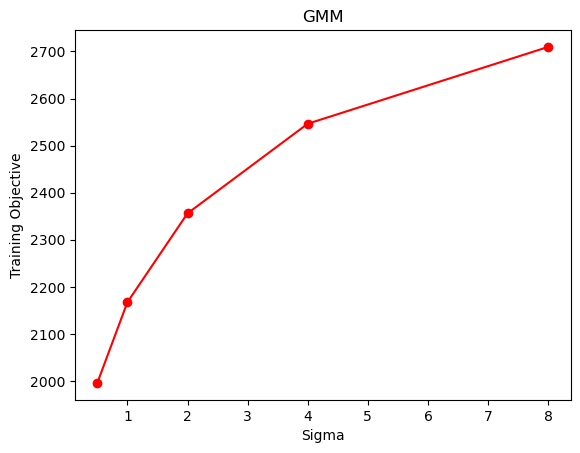

In [29]:
ax = plt.gca()

# Plotting
plt.plot(sigmas, losses, 'ro-')

# Labels and Title
plt.xlabel('Sigma')
plt.ylabel('Training Objective')
plt.title('GMM')

plt.show()

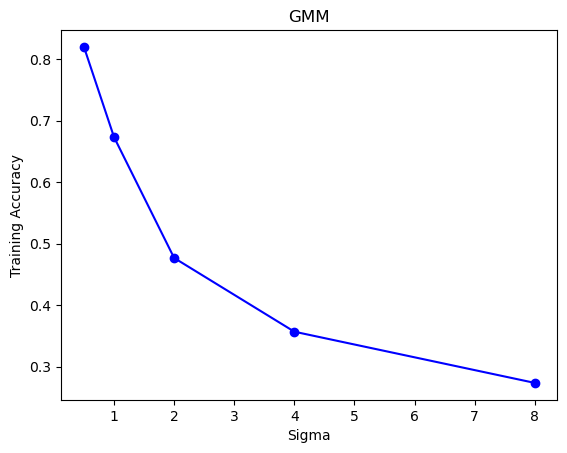

In [30]:
ax = plt.gca()

# Plotting
plt.plot(sigmas, accs, 'bo-')

# Labels and Title
plt.xlabel('Sigma')
plt.ylabel('Training Accuracy')
plt.title('GMM')

plt.show()

In [31]:
### Problem 2.2

In [32]:
# Import Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
df2 = pd.read_csv('data/data2D.csv', header=None)

d2 = df2.values

In [34]:
df1000 = pd.read_csv('data/data1000D.csv', header=None)

d1000 = df1000.values

In [35]:
## Computing the knee point

_, S, _ = np.linalg.svd(d1000)

Text(0.5, 1.0, 'Top 50 singular values')

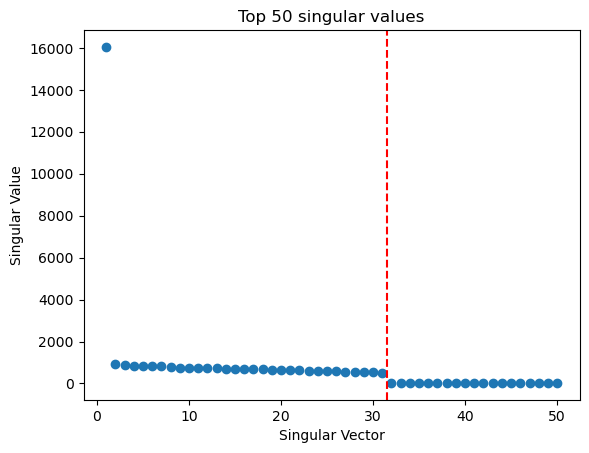

In [36]:
## d = 31 is our knee point

plt.scatter(np.arange(1, 51), S[:50])

plt.axvline(x=31.5, color='red', linestyle='--')

plt.xlabel('Singular Vector')
plt.ylabel('Singular Value')

plt.title('Top 50 singular values')

In [37]:
## buggy PCA when not pre-processed

def BasePCA(X, d):
    _, _, Vh = np.linalg.svd(X)
    
    # Lower dimensional space
    Vd = Vh[:d]

    # Returns d-dimensional repr, params, reconstructions
    return X @ Vd.T, Vd, X @ Vd.T @ Vd

In [38]:
def demeanedPCA(X, d):
    mean = np.mean(X, axis=0)
    Y = X - mean
    lowd, params, recon = BasePCA(Y, d)
    
    # Returns d-dimensional repr, params, reconstructions
    return lowd, (params, mean), recon + mean

In [39]:
def normPCA(X, d):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    Y = (X - mean) / std
    lowd, params, recon = BasePCA(Y, d)

    # Returns d-dimensional repr, params, reconstructions
    return lowd, (params, mean, std), recon* std + mean

In [40]:
def DRO(X, d):
    b = np.mean(X, axis=0)
    Y = X - b
    
    n = Y.shape[0]
    _, S, Vh = np.linalg.svd(Y)
    Vd = Vh[:d]
    Sd = np.diag(S[:d])
    
    A = 1 / np.sqrt(n) * Vd.T @ Sd
    # Alternatively, we could use the top-d vectors from U directly
    # but I wanted to reconstruct from Y instead
    Z = Y @ A @ np.linalg.inv(A.T @ A)
    # Can also reconstruct using Vd, Sd
    # Sd_inv = np.diag(1 / S[:d])
    # Z = np.sqrt(n) * Y @ Vd.T @ Sd_inv
    
    # Returns d-dimensional repr, params, reconstructions
    return Z, (Z, A, b), Z @ A.T + b

In [41]:
## error

def mse(rec, orig):
    return np.mean(np.sum(np.square(orig - rec), axis=1), axis=0)

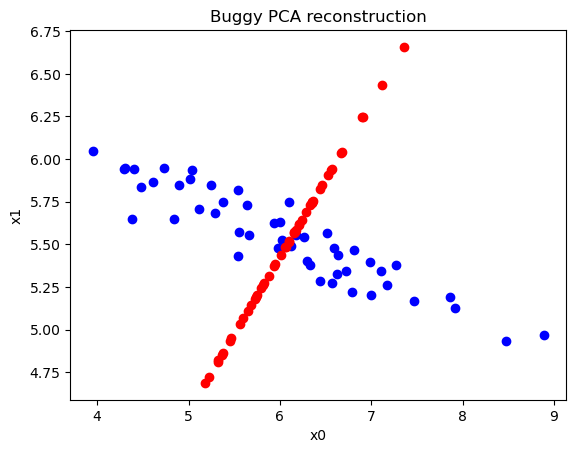

0.8869030837347941

In [42]:
## Buggy reconstructed

_, _, buggy = BasePCA(d2, 1)

plt.scatter(d2[:, 0], d2[:, 1], color='b')
plt.scatter(buggy[:, 0], buggy[:, 1], color='r')

plt.xlabel('x0')
plt.ylabel('x1')

plt.title('Buggy PCA reconstruction')

plt.show()

mse(buggy, d2)

0.010006085628512917

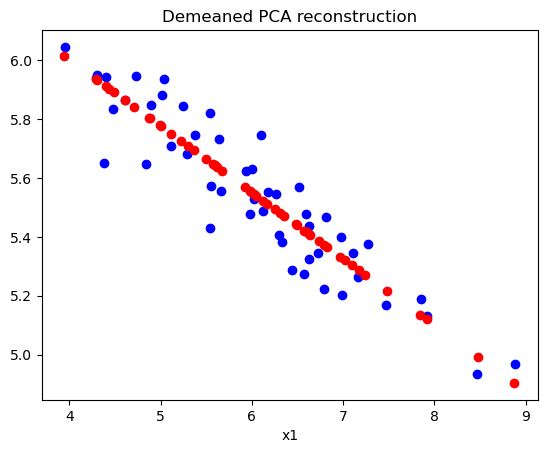

In [43]:
## Demeaned reconstructed

_, _, demeaned = demeanedPCA(d2, 1)

plt.scatter(d2[:, 0], d2[:, 1], color='b')
plt.scatter(demeaned[:, 0], demeaned[:, 1], color='r')


plt.xlabel('x0')
plt.xlabel('x1')

plt.title('Demeaned PCA reconstruction')

mse(demeaned, d2)

0.04947208345477067

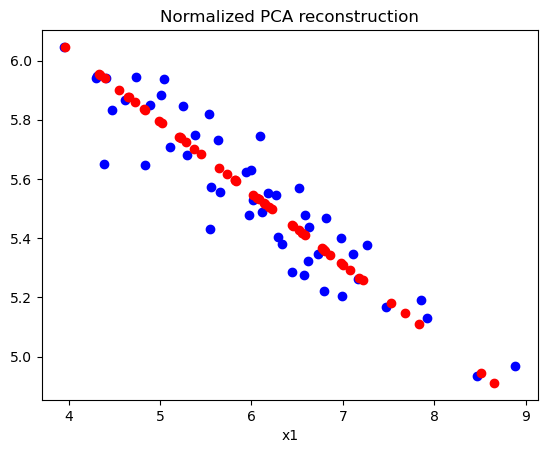

In [44]:
## Norm reconstructed

_, _, norm = normPCA(d2, 1)

plt.scatter(d2[:, 0], d2[:, 1], color='b')
plt.scatter(norm[:, 0], norm[:, 1], color='r')

plt.xlabel('x0')
plt.xlabel('x1')

plt.title('Normalized PCA reconstruction')

mse(norm, d2)

0.010006085628512922

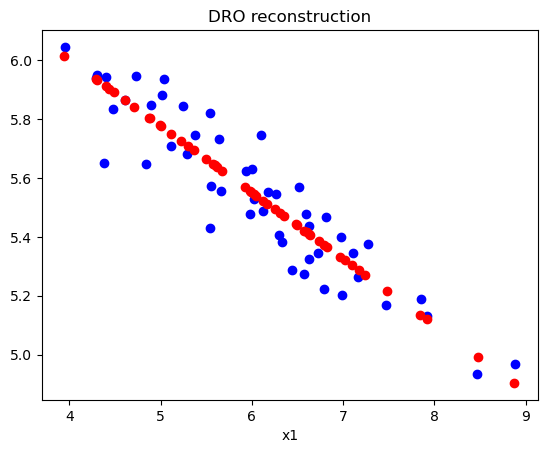

In [45]:
## DRO reconstructed

_, _, dro = DRO(d2, 1)

plt.scatter(d2[:, 0], d2[:, 1], color='b')
plt.scatter(dro[:, 0], dro[:, 1], color='r')


plt.xlabel('x0')
plt.xlabel('x1')

plt.title('DRO reconstruction')

mse(dro, d2)

In [46]:
d = 31

_, _, buggy = BasePCA(d1000, d)
_, _, demeaned = demeanedPCA(d1000, d)
_, _, norm = normPCA(d1000, d)
_, _, dro = DRO(d1000, d)

mse(buggy, d1000), mse(demeaned, d1000), mse(norm, d1000), mse(dro, d1000)

(272.7699492218145, 271.395604221274, 272.05892677540345, 271.3956042212741)

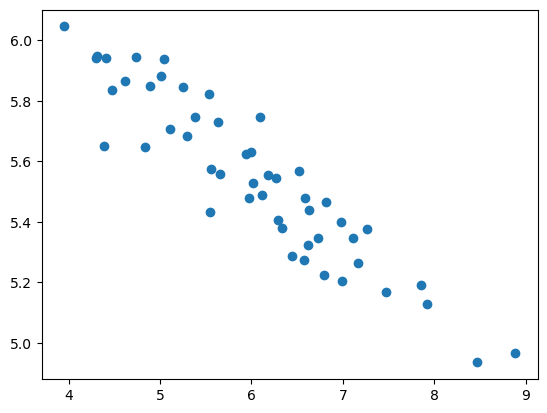

In [47]:
# Plot the values

plt.scatter(d2[:, 0], d2[:, 1])

plt.show()

In [48]:
# Testing only (below code do not directly answer the questions)

In [49]:
from sklearn.cluster import KMeans
from scipy import stats

X = sample_mixture(8)
kmeans = KMeans(n_clusters=3, n_init='auto').fit(X)

true_clusters = np.empty(300)
true_clusters[:100] = stats.mode(kmeans.labels_[:100])[0]
true_clusters[100:200] = stats.mode(kmeans.labels_[100:200])[0]
true_clusters[200:300] = stats.mode(kmeans.labels_[200:300])[0]

(kmeans.labels_ == true_clusters).mean()

0.5133333333333333

In [50]:
from sklearn.mixture import GaussianMixture
from scipy import stats

X = sample_mixture(0.5)
gmm = GaussianMixture(n_components=3).fit_predict(X)

true_clusters = np.empty(300)
true_clusters[:100] = stats.mode(gmm[:100])[0]
true_clusters[100:200] = stats.mode(gmm[100:200])[0]
true_clusters[200:300] = stats.mode(gmm[200:300])[0]

(gmm == true_clusters).mean()

0.7733333333333333